# Reducing hospital readmissions

## 📖 Background
You work for a consulting company helping a hospital group better understand patient readmissions. The hospital gave you access to ten years of information on patients readmitted to the hospital after being discharged. The doctors want you to assess if initial diagnoses, number of procedures, or other variables could help them better understand the probability of readmission. 

They want to focus follow-up calls and attention on those patients with a higher probability of readmission.

## 💾 The data
You have access to ten years of patient information ([source](https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008)):

#### Information in the file
- "age" - age bracket of the patient
- "time_in_hospital" - days (from 1 to 14)
- "n_procedures" - number of procedures performed during the hospital stay
- "n_lab_procedures" - number of laboratory procedures performed during the hospital stay
- "n_medications" - number of medications administered during the hospital stay
- "n_outpatient" - number of outpatient visits in the year before a hospital stay
- "n_inpatient" - number of inpatient visits in the year before the hospital stay
- "n_emergency" - number of visits to the emergency room in the year before the hospital stay
- "medical_specialty" - the specialty of the admitting physician
- "diag_1" - primary diagnosis (Circulatory, Respiratory, Digestive, etc.)
- "diag_2" - secondary diagnosis
- "diag_3" - additional secondary diagnosis
- "glucose_test" - whether the glucose serum came out as high (> 200), normal, or not performed
- "A1Ctest" - whether the A1C level of the patient came out as high (> 7%), normal, or not performed
- "change" - whether there was a change in the diabetes medication ('yes' or 'no')
- "diabetes_med" - whether a diabetes medication was prescribed ('yes' or 'no')
- "readmitted" - if the patient was readmitted at the hospital ('yes' or 'no') 

***Acknowledgments**: Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore, "Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records," BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014.*

## 💪 Competition challenge
Create a report that covers the following:

1. What is the most common primary diagnosis by age group? 
2. Some doctors believe diabetes might play a central role in readmission. Explore the effect of a diabetes diagnosis on readmission rates. 
3. On what groups of patients should the hospital focus their follow-up efforts to better monitor patients with a high probability of readmission?

# Imports

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

sns.set_style('whitegrid')

In [97]:
admissions = pd.read_csv('data/hospital_readmissions.csv')

# target variable
target = 'readmitted'

In [98]:
admissions['diagnoses'] = admissions[['diag_1', 'diag_2', 'diag_3']].apply(lambda x: list(set([x[0], x[1], x[2]])), axis = 1)
admissions['diabetes'] = admissions['diagnoses'].apply(lambda x: 1 if 'Diabetes' in x else 0)
admissions['diabetes_is_primary'] = admissions['diag_1'].apply(lambda x: 1 if x == 'Diabetes' else 0)

In [99]:
readmitted_mapping = {
    'no': 0,
    'yes': 1
}

admissions['readmitted'] = admissions['readmitted'].map(readmitted_mapping)

In [101]:
admissions.head(3)

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted,diagnoses,diabetes,diabetes_is_primary
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,0,"[Respiratory, Other, Circulatory]",0,0
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,0,[Other],0,0
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,1,[Circulatory],0,0


# Q1. What is the most common primary diagnosis by age group?

The most common primary diagnosis of:
- the 40-50 cohort is Other
- the 50-60 cohort is Circulatory
- the 60-70 cohort is Circulatory
- the 70-80 cohort is Circulatory
- the 80-90 cohort is Circulatory
- the 90-100 cohort is Circulatory


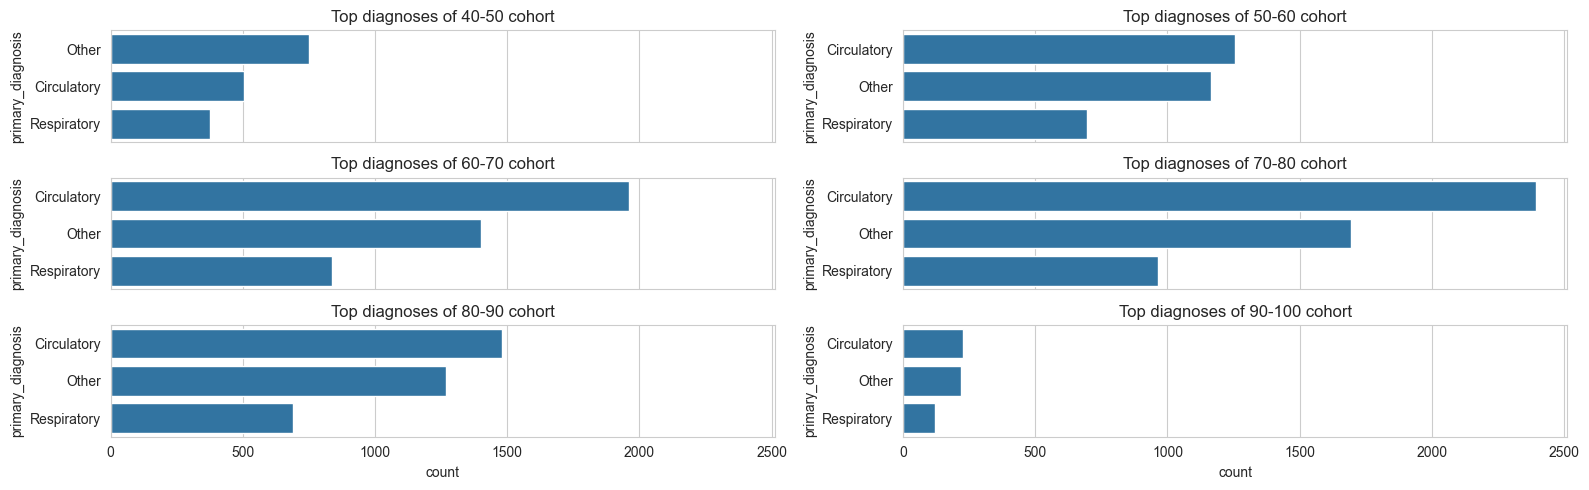

In [102]:
fig, axs = plt.subplots(3, 2, figsize = (16, 5), sharex = True)
axs = axs.flatten()

age_groups = sorted(admissions['age'].unique())

df = admissions.copy()
df = df.groupby(['diag_1','age'])['time_in_hospital'].count().reset_index()
df.columns = ['primary_diagnosis', 'age_group', 'count']

i = 0
print(f"The most common primary diagnosis of:")
for age_group in age_groups:
    tmp = df[df['age_group'] == age_group].reset_index(drop = True)
    tmp = tmp.sort_values(by = 'count', ascending = False)
    
    print(f"- the {tmp.iloc[0]['age_group'][1:-1]} cohort is {tmp.iloc[0]['primary_diagnosis']}")
    
    sns.barplot(data = tmp.head(3), x = 'count', y = 'primary_diagnosis', ax = axs[i])
    axs[i].set_title(f"Top diagnoses of {age_group[1:-1]} cohort")
    i += 1
plt.tight_layout()

# Q2. Some doctors believe diabetes might play a central role in readmission. Explore the effect of a diabetes diagnosis on readmission rates.

## Flagging diabetes instances

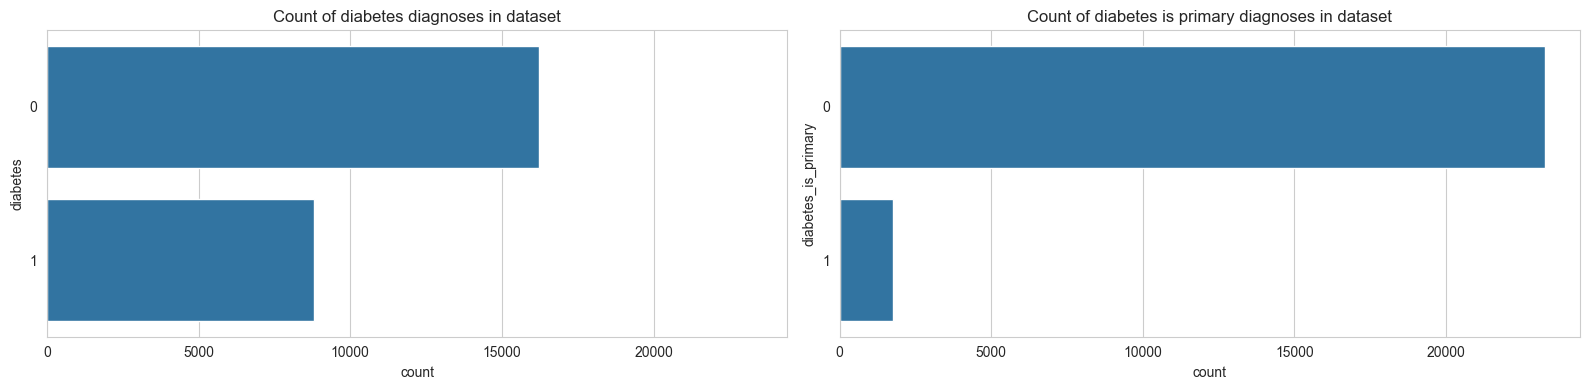

In [103]:
df = admissions.copy()
fig, axs = plt.subplots(1, 2, figsize = (16, 4), sharex = True)
sns.countplot(data = df, y = 'diabetes', ax = axs[0])
axs[0].set_title("Count of diabetes diagnoses in dataset")

sns.countplot(data = df, y = 'diabetes_is_primary', ax = axs[1])
axs[1].set_title("Count of diabetes is primary diagnoses in dataset")

plt.tight_layout()

## Crosstab of diabetes and readmission rates

Note: readmitted = 1, refers to an instance of hospital readmission

In [198]:
# Readmission rates with and without diabetes diagnosis
ct = pd.crosstab(admissions['diabetes'], admissions['readmitted'], normalize='index') * 100
ct = ct.applymap(lambda x: f"{x:.1f}%")
ct

readmitted,0,1
diabetes,,
0,52.7%,47.3%
1,53.5%,46.5%


In [199]:
# Readmission rates with and without diabetes as primary diagnosis
ct = pd.crosstab(admissions['diabetes_is_primary'], admissions['readmitted'], normalize='index') * 100
ct = ct.applymap(lambda x: f"{x:.1f}%")
ct

readmitted,0,1
diabetes_is_primary,,
0,53.5%,46.5%
1,46.4%,53.6%


Comment: diabetes_is_primary shows greater instances of hospital readmission than diabetes alone

In [215]:
# Readmission rates with and without diabetes diagnosis by age cohort
ct = pd.crosstab(index = [admissions['age'], admissions['diabetes']], columns = admissions['readmitted'], normalize='index') * 100
ct = ct.applymap(lambda x: f"{x:.1f}%")
ct

readmitted             0      1
age      diabetes              
[40-50)  0         56.5%  43.5%
         1         54.6%  45.4%
[50-60)  0         55.4%  44.6%
         1         56.4%  43.6%
[60-70)  0         52.3%  47.7%
         1         54.7%  45.3%
[70-80)  0         51.0%  49.0%
         1         51.7%  48.3%
[80-90)  0         51.3%  48.7%
         1         47.8%  52.2%
[90-100) 0         58.3%  41.7%
         1         56.6%  43.4%

## Tracking diabetes effect on readmissions across age cohort

In [164]:
tmp = df.groupby(['age', 'diabetes'])['readmitted'].sum().reset_index()
tmp = pd.pivot(data = tmp, index = 'age', columns = 'diabetes', values = 'readmitted')
tmp.columns = ['diabetes_no', 'diabetes_yes']
tmp['total'] = tmp.sum(axis = 1)

tmp2 = tmp.copy()
tmp2['diabetes_no'] = tmp2['diabetes_no'] / tmp2['total']
tmp2['diabetes_yes'] = tmp2['diabetes_yes'] / tmp2['total']
tmp2 = tmp2.drop('total', axis = 1).reset_index()
tmp2

,age,diabetes_no,diabetes_yes
0,[40-50),0.465839,0.534161
1,[50-60),0.570702,0.429298
2,[60-70),0.658484,0.341516
3,[70-80),0.692446,0.307554
4,[80-90),0.735596,0.264404
5,[90-100),0.750000,0.250000


In [169]:
tmp3 = df.groupby(['age', 'diabetes_is_primary'])['readmitted'].sum().reset_index()
tmp3 = pd.pivot(data = tmp3, index = 'age', columns = 'diabetes_is_primary', values = 'readmitted')
tmp3.columns = ['diabetes_primary_no', 'diabetes_primary_yes']
tmp3['total'] = tmp3.sum(axis = 1)

tmp4 = tmp3.copy()
tmp4['diabetes_primary_no'] = tmp4['diabetes_primary_no'] / tmp4['total']
tmp4['diabetes_primary_yes'] = tmp4['diabetes_primary_yes'] / tmp4['total']
tmp4 = tmp4.drop('total', axis = 1).reset_index()
tmp4

,age,diabetes_primary_no,diabetes_primary_yes
0,[40-50),0.826974,0.173026
1,[50-60),0.893184,0.106816
2,[60-70),0.928159,0.071841
3,[70-80),0.934652,0.065348
4,[80-90),0.956677,0.043323
5,[90-100),0.943038,0.056962


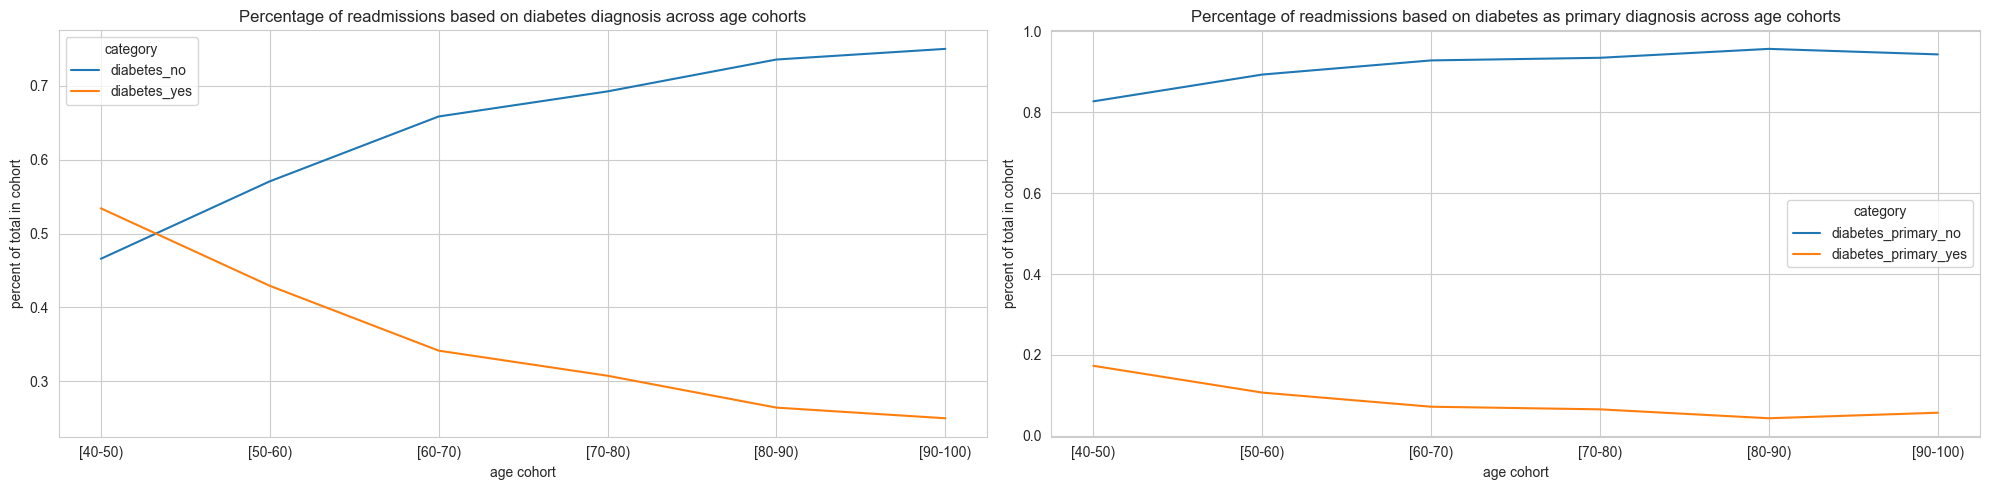

In [173]:
fig, axs = plt.subplots(1, 2, figsize = (20, 5))
tmp5 = pd.melt(tmp2, id_vars = 'age')
tmp5.columns = ['age', 'category', 'pct']

sns.lineplot(data = tmp5, x = 'age', y = 'pct', hue = 'category', ax = axs[0])
axs[0].set_title("Percentage of readmissions based on diabetes diagnosis across age cohorts")
axs[0].set_ylabel("percent of total in cohort")
axs[0].set_xlabel("age cohort")

tmp6 = pd.melt(tmp4, id_vars = 'age')
tmp6.columns = ['age', 'category', 'pct']


sns.lineplot(data = tmp6, x = 'age', y = 'pct', hue = 'category', ax = axs[1])
axs[1].set_title("Percentage of readmissions based on diabetes as primary diagnosis across age cohorts")
axs[1].set_ylabel("percent of total in cohort")
axs[1].set_xlabel("age cohort")


plt.tight_layout()

## Logistic regression to understand effect of diabetes on readmission

### Model 1

In [135]:
tmp = admissions.copy()
items = [
    'age',
    'diabetes',
    'diabetes_is_primary',
    'readmitted'
]

tmp = tmp[items]
tmp = pd.get_dummies(tmp, drop_first = True)

features = [f for f in tmp.columns if f != 'readmitted']
X = tmp[features]
X = sm.add_constant(X)
y = tmp['readmitted']

In [136]:
# Check for multicollinearity using VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data.sort_values(by = "VIF", ascending = False)

,feature,VIF
0,const,11.148840
5,age_[70-80),2.737349
4,age_[60-70),2.577507
6,age_[80-90),2.337861
3,age_[50-60),2.276580
7,age_[90-100),1.268812
1,diabetes,1.185317
2,diabetes_is_primary,1.165323


In [137]:
model1 = sm.Logit(y, X).fit()
model1.summary()

Optimization terminated successfully.
         Current function value: 0.689434
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                25000
Model:                          Logit   Df Residuals:                    24992
Method:                           MLE   Df Model:                            7
Date:                Wed, 15 May 2024   Pseudo R-squ.:                0.002794
Time:                        09:08:11   Log-Likelihood:                -17236.
converged:                       True   LL-Null:                       -17284.
Covariance Type:            nonrobust   LLR p-value:                 5.459e-18
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.2339      0.043     -5.497      0.000      -0.317      -0.151
diabetes               -0.0786      0.029     -2.712      0.007      -0.135      -0.022
diabetes_is_primary     0.3708      0.054      6.893      0.000       0.265       0.476
age_[50-60)             0.0003      0.050      0.006      0.996      -0.098       0.099
age_[60-70)             0.1111      0.048      2.310      0.021       0.017       0.205
age_[70-80)             0.1892      0.047      4.005      0.000       0.097       0.282
age_[80-90)             0.2220      0.051      4.393      0.000       0.123       0.321
age_[90-100)           -0.0814      0.085     -0.963      0.335      -0.247       0.084
=======================================================================================
"""

### Model 2

In [139]:
tmp = admissions.copy()

items = [
    'age',
    'diabetes',
    'diabetes_is_primary',
    'time_in_hospital',
    'n_emergency',
    'n_inpatient',
    'n_lab_procedures',
    'n_medications',
    'n_outpatient',
    'n_procedures',
    'readmitted'
]

tmp = pd.get_dummies(tmp[items], drop_first = True)

features = [f for f in tmp.columns if f != 'readmitted']
X = tmp[features]
X = sm.add_constant(X)
y = tmp['readmitted']

In [140]:
# Check for multicollinearity using VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data.sort_values(by = "VIF", ascending = False)

,feature,VIF
0,const,18.939862
12,age_[70-80),2.764961
11,age_[60-70),2.602073
13,age_[80-90),2.376489
10,age_[50-60),2.287079
7,n_medications,1.473982
3,time_in_hospital,1.364939
14,age_[90-100),1.281421
1,diabetes,1.213128
9,n_procedures,1.196593


In [141]:
model2 = sm.Logit(y, X).fit()
model2.summary()

Optimization terminated successfully.
         Current function value: 0.659525
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                25000
Model:                          Logit   Df Residuals:                    24985
Method:                           MLE   Df Model:                           14
Date:                Wed, 15 May 2024   Pseudo R-squ.:                 0.04605
Time:                        09:08:52   Log-Likelihood:                -16488.
converged:                       True   LL-Null:                       -17284.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.7540      0.058    -13.089      0.000      -0.867      -0.641
diabetes               -0.0014      0.030     -0.046      0.964      -0.060       0.058
diabetes_is_primary     0.2396      0.056      4.282      0.000       0.130       0.349
time_in_hospital        0.0117      0.005      2.298      0.022       0.002       0.022
n_emergency             0.2197      0.025      8.671      0.000       0.170       0.269
n_inpatient             0.3861      0.014     26.848      0.000       0.358       0.414
n_lab_procedures        0.0014      0.001      1.963      0.050    2.06e-06       0.003
n_medications           0.0057      0.002      2.891      0.004       0.002       0.010
n_outpatient            0.1203      0.013      9.176      0.000       0.095       0.146
n_procedures           -0.0416      0.008     -4.968      0.000      -0.058      -0.025
age_[50-60)             0.0525      0.052      1.001      0.317      -0.050       0.155
age_[60-70)             0.1766      0.050      3.512      0.000       0.078       0.275
age_[70-80)             0.2512      0.049      5.089      0.000       0.154       0.348
age_[80-90)             0.2646      0.053      5.008      0.000       0.161       0.368
age_[90-100)           -0.0151      0.087     -0.173      0.863      -0.186       0.156
=======================================================================================
"""

### Model 3

In [147]:
tmp = admissions.copy()

items = [
    'age',
    'diabetes_is_primary',
    'time_in_hospital',
    'n_emergency',
    'n_inpatient',
    'n_lab_procedures',
    'n_medications',
    'n_outpatient',
    'readmitted'
]

tmp = pd.get_dummies(tmp[items], drop_first = True)

features = [f for f in tmp.columns if f != 'readmitted']
X = tmp[features]
X = sm.add_constant(X)
y = tmp['readmitted']

In [148]:
# Check for multicollinearity using VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data.sort_values(by = "VIF", ascending = False)

,feature,VIF
0,const,17.056798
10,age_[70-80),2.742397
9,age_[60-70),2.590388
11,age_[80-90),2.336615
8,age_[50-60),2.285167
2,time_in_hospital,1.357991
6,n_medications,1.316442
12,age_[90-100),1.270050
5,n_lab_procedures,1.148820
4,n_inpatient,1.073184


In [149]:
model3 = sm.Logit(y, X).fit()
model3.summary()

Optimization terminated successfully.
         Current function value: 0.660021
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                25000
Model:                          Logit   Df Residuals:                    24987
Method:                           MLE   Df Model:                           12
Date:                Wed, 15 May 2024   Pseudo R-squ.:                 0.04534
Time:                        09:13:49   Log-Likelihood:                -16501.
converged:                       True   LL-Null:                       -17284.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.7704      0.055    -14.082      0.000      -0.878      -0.663
diabetes_is_primary     0.2501      0.052      4.797      0.000       0.148       0.352
time_in_hospital        0.0105      0.005      2.070      0.038       0.001       0.020
n_emergency             0.2245      0.025      8.847      0.000       0.175       0.274
n_inpatient             0.3921      0.014     27.339      0.000       0.364       0.420
n_lab_procedures        0.0016      0.001      2.257      0.024       0.000       0.003
n_medications           0.0025      0.002      1.343      0.179      -0.001       0.006
n_outpatient            0.1226      0.013      9.350      0.000       0.097       0.148
age_[50-60)             0.0494      0.052      0.942      0.346      -0.053       0.152
age_[60-70)             0.1720      0.050      3.431      0.001       0.074       0.270
age_[70-80)             0.2534      0.049      5.155      0.000       0.157       0.350
age_[80-90)             0.2806      0.052      5.355      0.000       0.178       0.383
age_[90-100)            0.0089      0.087      0.103      0.918      -0.161       0.179
=======================================================================================
"""

### Conclusion

- Model 2 fits the data best;
- 'diabetes_is_primary' is a significant coefficient in predicting hospital readmission
- 'diabetes' alone does not predict hospital readmission

# Q3. On what groups of patients should the hospital focus their follow-up efforts to better monitor patients with a high probability of readmission?

In [150]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                25000
Model:                          Logit   Df Residuals:                    24985
Method:                           MLE   Df Model:                           14
Date:                Wed, 15 May 2024   Pseudo R-squ.:                 0.04605
Time:                        09:19:42   Log-Likelihood:                -16488.
converged:                       True   LL-Null:                       -17284.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.7540      0.058    -13.089      0.000      -0.867      -0.641
diabetes               -0.0014      0.030     -0.046      0.964      -0.060       0.058
diabetes_is_primary     0.2396      0.056      4.282      0.000       0.130       0.349
time_in_hospital        0.0117      0.005      2.298      0.022       0.002       0.022
n_emergency             0.2197      0.025      8.671      0.000       0.170       0.269
n_inpatient             0.3861      0.014     26.848      0.000       0.358       0.414
n_lab_procedures        0.0014      0.001      1.963      0.050    2.06e-06       0.003
n_medications           0.0057      0.002      2.891      0.004       0.002       0.010
n_outpatient            0.1203      0.013      9.176      0.000       0.095       0.146
n_procedures           -0.0416      0.008     -4.968      0.000      -0.058      -0.025
age_[50-60)             0.0525      0.052      1.001      0.317      -0.050       0.155
age_[60-70)             0.1766      0.050      3.512      0.000       0.078       0.275
age_[70-80)             0.2512      0.049      5.089      0.000       0.154       0.348
age_[80-90)             0.2646      0.053      5.008      0.000       0.161       0.368
age_[90-100)           -0.0151      0.087     -0.173      0.863      -0.186       0.156
=======================================================================================
"""

## Conclusions

Based on Model2's output, the hospital should focus on the following factors:
- whether the patient's primary diagnosis is Diabetes
- how many visits to the emergency room in the year prior to hospital stay
- number of inpatient visits in the year before the hospital stay
- number of outpatient visits in the year before a hospital stay

Patients with a Diabetes as Primary Diagnosis are about 1.27 times higher odds of hospital readmission than those who were not, all other factors constant.